In [62]:
import pandas as pd
import numpy as np
import yfinance as yf 
from scipy.stats import norm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys
# !{sys.executable} -m pip install plotly
import plotly.graph_objects as go
# !pip install numpy_financial
import numpy_financial as npf


In [63]:
ticker = "RY.TO" # RBC

1. Merton/KMV

In [64]:
# 1. Load stock data
ticker = "RY.TO"
stock = yf.Ticker(ticker)
stock_data = yf.download(ticker, start="2024-04-01", end="2025-04-01")

# 2. Compute annualized equity volatility (σ_S)
stock_data["Log_Returns"] = np.log(stock_data["Close"] / stock_data["Close"].shift(1))
stock_data.dropna(inplace=True)
sigma_S = stock_data["Log_Returns"].std() * np.sqrt(252)

# 3. Get market cap (S) and risk-free rate
S_observed = stock.info["marketCap"]  # This is S (equity value)
r = 0.04  # 4% risk-free rate

# 4. Get debt from balance sheet
balance_sheet = stock.balance_sheet
short_term_debt = balance_sheet.loc["Current Debt"].iloc[0]
long_term_debt = balance_sheet.loc["Long Term Debt"].iloc[0]
K = short_term_debt + 0.5 * long_term_debt  # Effective debt

# 5. Set total firm value (V) = observed equity + debt (your assumption)
V = S_observed + K  # This is fixed in your model

# 6. Merton model function: fixed V, solve for σ_A and compute S
def estimate_sigma_and_pd(sigma_S, K, r, T, V_fixed, tol=1e-8, max_iter=100):
    sigma_A = sigma_S  # initial guess
    for _ in range(max_iter):
        d1 = (np.log(V_fixed / K) + (r + 0.5 * sigma_A**2) * T) / (sigma_A * np.sqrt(T))
        d2 = d1 - sigma_A * np.sqrt(T)
        
        S_calc = V_fixed * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  # option value
        delta = norm.cdf(d1)
        sigma_A_new = (sigma_S * S_calc) / (V_fixed * delta)
        
        if abs(sigma_A - sigma_A_new) < tol:
            break
        sigma_A = sigma_A_new

    d = norm.cdf(-d2)  # Probability of default
    return d, S_calc, sigma_A, d2

# 7. Compute default probabilities for 1–50 years
years = np.arange(1, 51)
merton_default_probs = []

for T in years:
    d, S_est, sigma_A_est, d2 = estimate_sigma_and_pd(sigma_S, K, r, T, V)
    merton_default_probs.append(d)

# 7. Plotting
# df = pd.DataFrame({
#     "Year": years,
#     "Merton Default Probability": merton_default_probs
# })

# merton_default_probs = df["Merton Default Probability"]
# plt.figure(figsize=(10, 5))
# plt.plot(df["Year"], merton_default_probs, marker="o")
# plt.title("Merton Model - RBC Cumulative Probability of Default (1–50 Years)")
# plt.xlabel("Year")
# plt.ylabel("Default Probability")
# plt.grid(True)
# plt.ylim(0, max(merton_default_probs) * 1.1)
# plt.show()

[*********************100%***********************]  1 of 1 completed


In [65]:
# 1 yr parameters
d, S_1yr, sigma_A_1yr, d2 = estimate_sigma_and_pd(sigma_S, K, r, 1, V)

print("=== Merton Model Parameters ===")
print(f"Time to Maturity (T): {T} year(s)")
print(f"Market Value of Equity (S): ${S_observed:,.2f}")
print(f"Equity Volatility (σ_S): {sigma_S:.4f}")
print(f"Debt (K): ${K:,.2f}")
print(f"Risk-free Rate (r): {r:.2%}")
print(f"Leverage: {K/V:.2%}")
print(f"Estimated Firm Value (V): ${V:,.2f}")
print(f"Estimated Asset Volatility (σ_V): {sigma_A_1yr:.4f}")


=== Merton Model Parameters ===
Time to Maturity (T): 50 year(s)
Market Value of Equity (S): $222,925,504,512.00
Equity Volatility (σ_S): 0.1548
Debt (K): $302,418,500,000.00
Risk-free Rate (r): 4.00%
Leverage: 57.57%
Estimated Firm Value (V): $525,344,004,512.00
Estimated Asset Volatility (σ_V): 0.0692


2. CreditMetrics

In [66]:
# 1. Define the credit rating mapping and transition matrix
dictRating = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6, 'D': 7}
ratings = list(dictRating.keys())

# CreditMetrics 1-year transition matrix (raw input)
transition_matrix = np.array([
    [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],  # AAA
    [0.0000, 0.9397, 0.0172, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431],  # AA
    [0.0000, 0.0098, 0.9431, 0.0412, 0.0000, 0.0000, 0.0000, 0.00059], # A
    [0.0000, 0.0000, 0.0281, 0.9264, 0.0147, 0.0000, 0.0000, 0.0308],  # BBB
    [0.0000, 0.0000, 0.0019, 0.0312, 0.8772, 0.0331, 0.0039, 0.0507],  # BB
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0400, 0.7863, 0.0411, 0.1095],  # B
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1116, 0.4093, 0.1860],  # CCC
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],  # D
]) # S&P: https://www.spglobal.com/ratings/en/research/articles/250327-default-transition-and-recovery-2024-annual-global-corporate-default-and-rating-transition-study-13452126

# 2. Normalize transition matrix rows to sum to 1
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = transition_matrix / row_sums  # broadcasting
transition_matrix = np.round(transition_matrix, 6)

# 3. Settings
initial_rating = 'AA'
initial_index = dictRating[initial_rating]
default_index = dictRating['D']
years = 50

# 4. Matrix squaring approach
lstDP_CM = []
P = transition_matrix.copy()
for i in range(1, years + 1):
    lstDP_CM.append(P[initial_index][default_index])  # Prob of default from initial_rating to 'D' in year i
    P = P @ transition_matrix  # Compute P^t

# 5. Output to DataFrame
df = pd.DataFrame({
    "Year": list(range(1, years + 1)),
    f"Default Probability from {initial_rating}": np.round(lstDP_CM, 6)
})
cm_default_probs = df.iloc[:, 1]

# 6. Plot
# plt.figure(figsize=(10, 5))
# plt.plot(df["Year"], cm_default_probs, marker="o")
# plt.title(f"CreditMetrics Model - Default Probability from {initial_rating} Rating")
# plt.xlabel("Year")
# plt.ylabel("Probability of Default")
# plt.grid(True)
# plt.ylim(0, max(lstDP_CM) * 1.2)
# plt.show()


3. Compare Default Probabilities of KVM and CreditMetrics

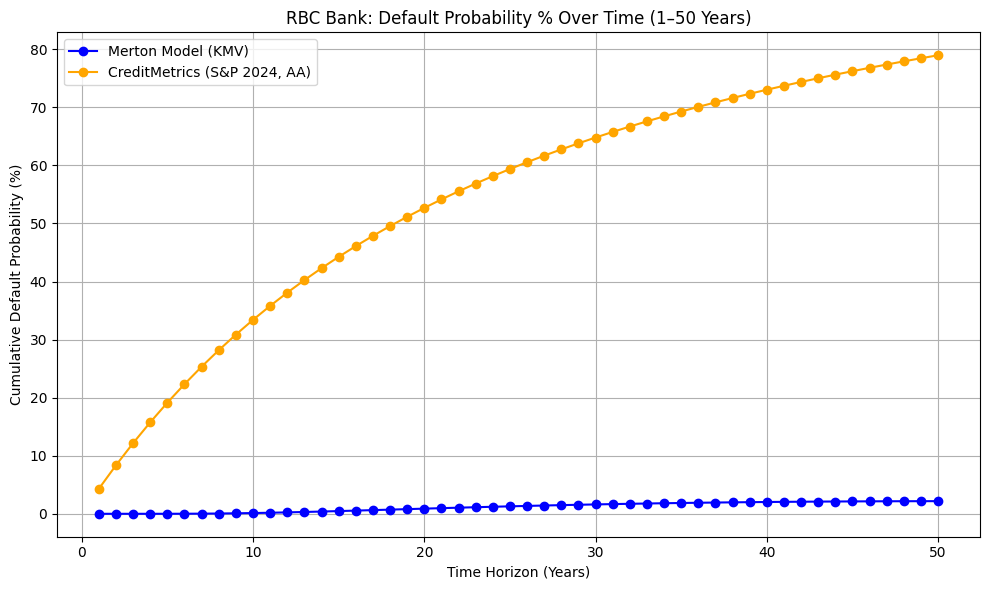

In [67]:
years = np.arange(1, 51)
plt.figure(figsize=(10, 6))
plt.plot(years, [rate * 100 for rate in merton_default_probs], marker='o', label="Merton Model (KMV)", color='blue')
plt.plot(years, [rate * 100 for rate in cm_default_probs], marker='o', label="CreditMetrics (S&P 2024, AA)", color='orange')

plt.title("RBC Bank: Default Probability % Over Time (1–50 Years)")
plt.xlabel("Time Horizon (Years)")
plt.ylabel("Cumulative Default Probability (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

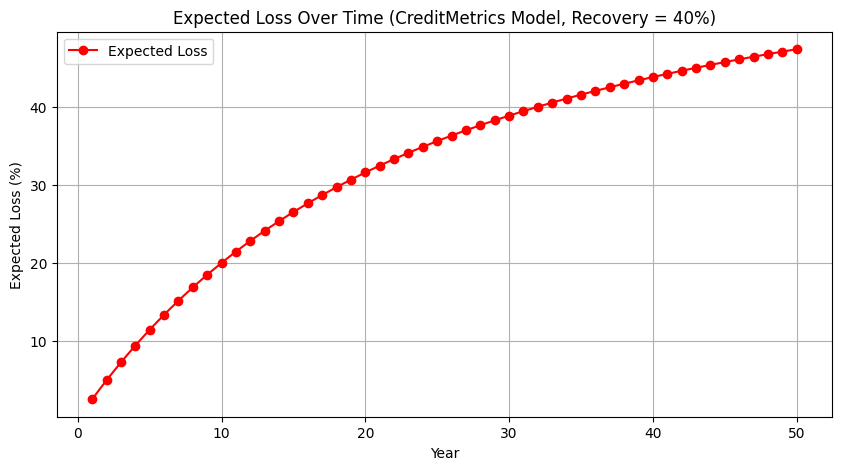

In [68]:
# Set Recovery Rate (e.g., 40% for senior unsecured bank debt)
recovery_rate = 0.40
lgd = 1 - recovery_rate  # Loss Given Default

# Calculate expected loss over time
expected_loss = [pd * lgd for pd in cm_default_probs]
df["Expected Loss (%)"] = [round(el * 100, 4) for el in expected_loss]

plt.figure(figsize=(10, 5))
plt.plot(df["Year"], df["Expected Loss (%)"], marker='o', color='red', label="Expected Loss")
plt.title("Expected Loss Over Time (CreditMetrics Model, Recovery = 40%)")
plt.xlabel("Year")
plt.ylabel("Expected Loss (%)")
plt.grid(True)
plt.legend()
plt.show()


4. Bond Yield

a. RBC Bond

In [69]:
data = pd.read_excel("/Users/tanshuxin/Desktop/utsg/2025 Winter/APM466/Assignments/A2/RBC bond price.xlsx")
data["Maturity Date"] = pd.to_datetime(data["Maturity Date"])
data["Current Date"] = pd.to_datetime(data["Current Date"])
data = data[:-2]
data = data.drop(index=1)
data

,ISIN,Coupon,Price,Maturity Date,Current Date
0,CA780085N938,0.04930,100.55,2025-07-16,2025-04-03
2,CA780086ZE76,0.05341,102.79,2026-06-23,2025-04-03
3,CA780086VV38,0.05235,103.13,2026-11-02,2025-04-03
4,CA780086VK72,0.04612,103.26,2027-07-26,2025-04-03
5,CA780086XL38,0.04632,103.84,2028-05-01,2025-04-03
6,CA779926FY56,0.03626,100.98,2028-12-10,2025-04-03
7,CA780086ZH08,0.05228,107.74,2030-06-24,2025-04-03
8,CA7800863G73,0.05096,104.55,2034-04-03,2025-04-03


In [70]:
from datetime import datetime, timedelta

def get_last_coupon_date(maturity_date, today=None):
    """
    Get the last coupon payment date before today (semiannual frequency).
    """
    if today is None:
        today = datetime.today()

    # Use as-is; assume datetime or Timestamp
    coupon_date = maturity_date

    # Step back in 6-month intervals until coupon_date is ≤ today
    while coupon_date > today:
        coupon_date -= timedelta(days=182)  # Approximate 6 months

    return coupon_date

def calculate_ytm(bonds):
    ytms = []
    for i, (price, coupon_rate, maturity) in enumerate(sorted(bonds, key=lambda x: x[2])):
            time_periods = []
            current_time = maturity
            while current_time > 0:
                time_periods.append(current_time)
                current_time -= 0.5
            time_periods = time_periods[::-1]

            nper = len(time_periods)
            pmt = coupon_rate / 2
            fv = 100
            pv = -price

            ytm = npf.rate(nper=nper, pmt=pmt, pv=pv, fv=fv) * 2

            ytms.append(ytm)
    return ytms


In [71]:
date = pd.to_datetime("2025-04-03")

clean_price = data["Price"]
data["Last Coupon Date"] = data.apply(
    lambda row: get_last_coupon_date(row["Maturity Date"], date), axis=1
)

days_difference = (pd.to_datetime(date) - data["Last Coupon Date"]).dt.days / 365
data["Dirty Price"] = days_difference * data["Coupon"] * 100 + clean_price

data.to_excel("RBC Bond Cleaned.xlsx", index=False)

In [72]:
d = pd.to_datetime(date)
data["Remaining Maturity"] = (pd.to_datetime(data["Maturity Date"]) - d).dt.days / 365

bonds = []
for i in range(len(data)):
    row = data.iloc[i]
    maturity = row["Remaining Maturity"]
    price = row["Price"]
    coupon = row["Coupon"] * 100  # assuming coupon is in decimal form (e.g., 0.03)
    bonds.append((price, coupon, maturity))

# Calculate YTM
yield_rates_1 = calculate_ytm(bonds)
maturities_1 = [bond[2] for bond in bonds]

b. Gov Bond

In [73]:
gov = pd.read_excel("/Users/tanshuxin/Desktop/utsg/2025 Winter/APM466/Assignments/A2/Gov Bond.xlsx")
gov["Maturity Date"] = pd.to_datetime(gov["Maturity Date"])
gov["Current Date"] = pd.to_datetime(gov["Current Date"])
gov

,ISIN,Coupon,Price,Maturity Date,Current Date
0,CA135087D507,0.0225,99.92,2025-06-01,2025-04-03
1,CA135087E679,0.0150,98.98,2026-06-01,NaT
2,CA135087F825,0.0100,97.12,2027-06-01,NaT
3,CA135087H235,0.0200,98.73,2028-06-01,NaT
4,CA135087J397,0.0225,99.18,2029-06-01,NaT
5,CA135087S471,0.0275,101.05,2030-03-01,NaT
6,CA135087M276,0.0150,93.50,2031-06-01,NaT
7,CA135087N597,0.0200,95.24,2032-06-01,NaT
8,CA135087Q723,0.0325,103.09,2033-12-01,NaT
9,CA135087S216,0.0325,102.88,2034-12-01,NaT


In [74]:
clean_price = gov["Price"]
gov["Last Coupon Date"] = gov.apply(
    lambda row: get_last_coupon_date(row["Maturity Date"], date), axis=1
)

days_difference = (pd.to_datetime(date) - gov["Last Coupon Date"]).dt.days / 365
gov["Dirty Price"] = days_difference * gov["Coupon"] * 100 + clean_price

gov

,ISIN,Coupon,Price,Maturity Date,Current Date,Last Coupon Date,Dirty Price
0,CA135087D507,0.0225,99.92,2025-06-01,2025-04-03,2024-12-01,100.678219
1,CA135087E679,0.0150,98.98,2026-06-01,NaT,2024-12-02,99.481370
2,CA135087F825,0.0100,97.12,2027-06-01,NaT,2024-12-03,97.451507
3,CA135087H235,0.0200,98.73,2028-06-01,NaT,2024-12-05,99.382055
4,CA135087J397,0.0225,99.18,2029-06-01,NaT,2024-12-06,99.907397
5,CA135087S471,0.0275,101.05,2030-03-01,NaT,2025-03-07,101.253425
6,CA135087M276,0.0150,93.50,2031-06-01,NaT,2024-12-08,93.976712
7,CA135087N597,0.0200,95.24,2032-06-01,NaT,2024-12-10,95.864658
8,CA135087Q723,0.0325,103.09,2033-12-01,NaT,2024-12-12,104.087260
9,CA135087S216,0.0325,102.88,2034-12-01,NaT,2024-12-13,103.868356


In [75]:
d = pd.to_datetime(date)
gov["Remaining Maturity"] = (pd.to_datetime(gov["Maturity Date"]) - d).dt.days / 365

bonds = []
for i in range(len(gov)):
    row = gov.iloc[i]
    maturity = row["Remaining Maturity"]
    price = row["Price"]
    coupon = row["Coupon"] * 100  # assuming coupon is in decimal form (e.g., 0.03)
    bonds.append((price, coupon, maturity))

# Calculate YTM
yield_rates_2 = calculate_ytm(bonds)
maturities_2 = [bond[2] for bond in bonds]

In [76]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=maturities_1,
#     y=[rate * 100 for rate in yield_rates_1],  # Convert to percentage
#     mode='lines+markers',
#     name="RBC Bond"
# ))
# fig.add_trace(go.Scatter(
#     x=maturities_2,
#     y=[rate * 100 for rate in yield_rates_2],  # Convert to percentage
#     mode='lines+markers',
#     name="Government Bond"
# ))
# fig.update_layout(
#     title="Yield Curve",
#     xaxis_title="Maturity (Years)",
#     yaxis_title="YTM (%)",
#     legend_title="Type"
# )
# fig.show()

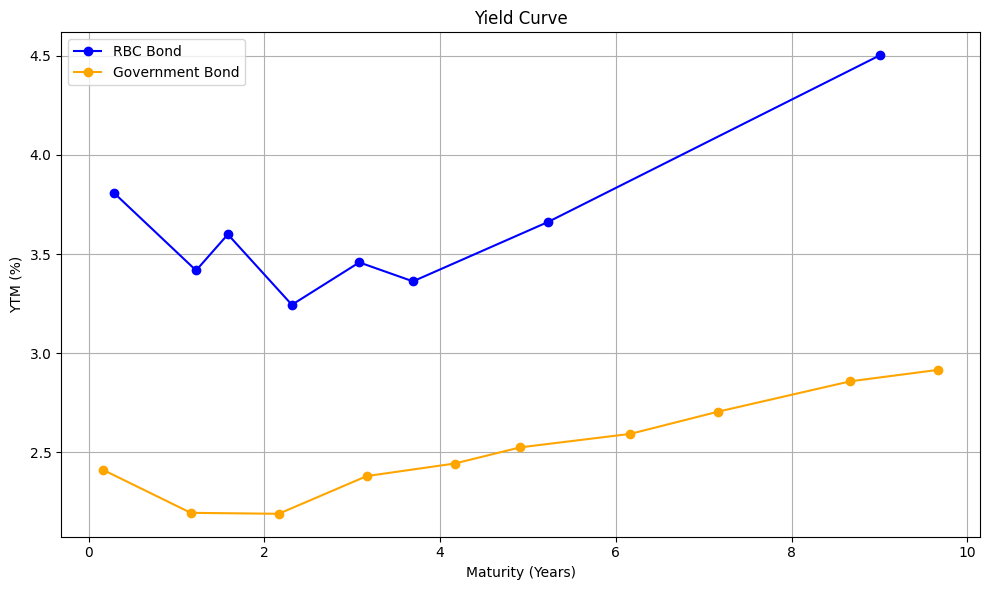

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(maturities_1, [rate * 100 for rate in yield_rates_1], marker='o', label="RBC Bond", color='blue')
plt.plot(maturities_2, [rate * 100 for rate in yield_rates_2], marker='o', label="Government Bond", color='orange')

plt.title("Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("YTM (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()